Topic Modelling
1- Used to get information from a very last dataset corpus without reading the actual text
2- eg: from a big criminal dataset we can get the information in which reason the crime is happening more etc.

Drawback of TF-IDF:
1- Every document will have only 1 topic, they cannot have multiple topics. To overcome this, LDA came into picture. LDA can have multiple topics for a document.
2- If the document is small less than 100 words, use TF-IDF else use LDA.


In [1]:
import pandas as pd
from sklearn.metrics import adjusted_rand_score
import string
from nltk.corpus import stopwords
import json 
import glob
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [2]:
def load_data(file):
    with open(file,"r",encoding="utf-8") as f:
        data = json.load(f)
    return (data)

In [3]:
def write_data(file,data):
    with open(file,"w",encoding="utf-8") as f:
        json.dump(data,f,indent=4)
    

In [4]:
def remove_stops(text,stops):
    text = re.sub(r"AC\/\d{1,4}\/\d{1,4}", "", text) #remove all of the AC numbers
    words = text.split()
    final = []
    for word in words:
        if word not in stops: #remove stops
            final.append(word)
    final = " ".join(final)
    final = final.translate(str.maketrans("","",string.punctuation)) #remove punctuations
    final = "".join([i for i in final if not i.isdigit()]) #remove digit
    while "  " in final:
        final = final.replace("  "," ") # remove double space with single space
    return (final)
    

In [5]:
def clean_docs(docs):
    #list of desc
    stops = stopwords.words("english")
    months = load_data("data/months.json")
    stops = stops + months
    final = []
    for doc in docs:
        clean_doc = remove_stops(doc,stops)
        final.append(clean_doc)
    return (final)


In [6]:
descriptions = load_data("data/trc_dn.json")["descriptions"]
names = load_data("data/trc_dn.json")["names"]

In [7]:
cleaned_docs = clean_docs(descriptions)

In [8]:
cleaned_docs[0]

'An ANCYL member shot severely injured SAP members Lephoi Bethulie Orange Free State OFS Police opened fire gathering ANC supporters house following dispute two neighbours one linked ANC SAP councillor'

In [9]:
vectorizer = TfidfVectorizer(
                                lowercase=True,
                                max_features=100,
                                max_df=0.8, #words that occurs more than 80% in all documents delete it
                                min_df=5, #less than 5 remove
                                ngram_range = (1,3), #1,2,3 gram all 3 will run
                                stop_words = "english"
                            )

vectors = vectorizer.fit_transform(cleaned_docs)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()

all_keywords = []

for description in denselist:
    x=0
    keywords = []
    for word in description:
        if word > 0:
            keywords.append(feature_names[x])
        x=x+1
    all_keywords.append(keywords)
    
print (descriptions[0])
print (all_keywords[0])



An ANCYL member who was shot and severely injured by SAP members at Lephoi, Bethulie, Orange Free State (OFS) on 17 April 1991. Police opened fire on a gathering at an ANC supporter's house following a dispute between two neighbours, one of whom was linked to the ANC and the other to the SAP and a councillor.
['anc', 'anc supporters', 'house', 'injured', 'member', 'members', 'police', 'sap', 'severely', 'shot', 'supporters']


In [10]:
true_k = 20
model = KMeans(n_clusters=true_k, init="k-means++", max_iter=100, n_init=1)

model.fit(vectors)

order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

with open ("data/trc_results.txt", "w", encoding="utf-8") as f:
    for i in range(true_k):
        f.write(f"Cluster {i}")
        f.write("\n")
        for ind in order_centroids[i, :10]:
            f.write (' %s' % terms[ind],)
            f.write("\n")
        f.write("\n")
        f.write("\n")


# Plotting


In [11]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [12]:
kmean_indices = model.fit_predict(vectors)

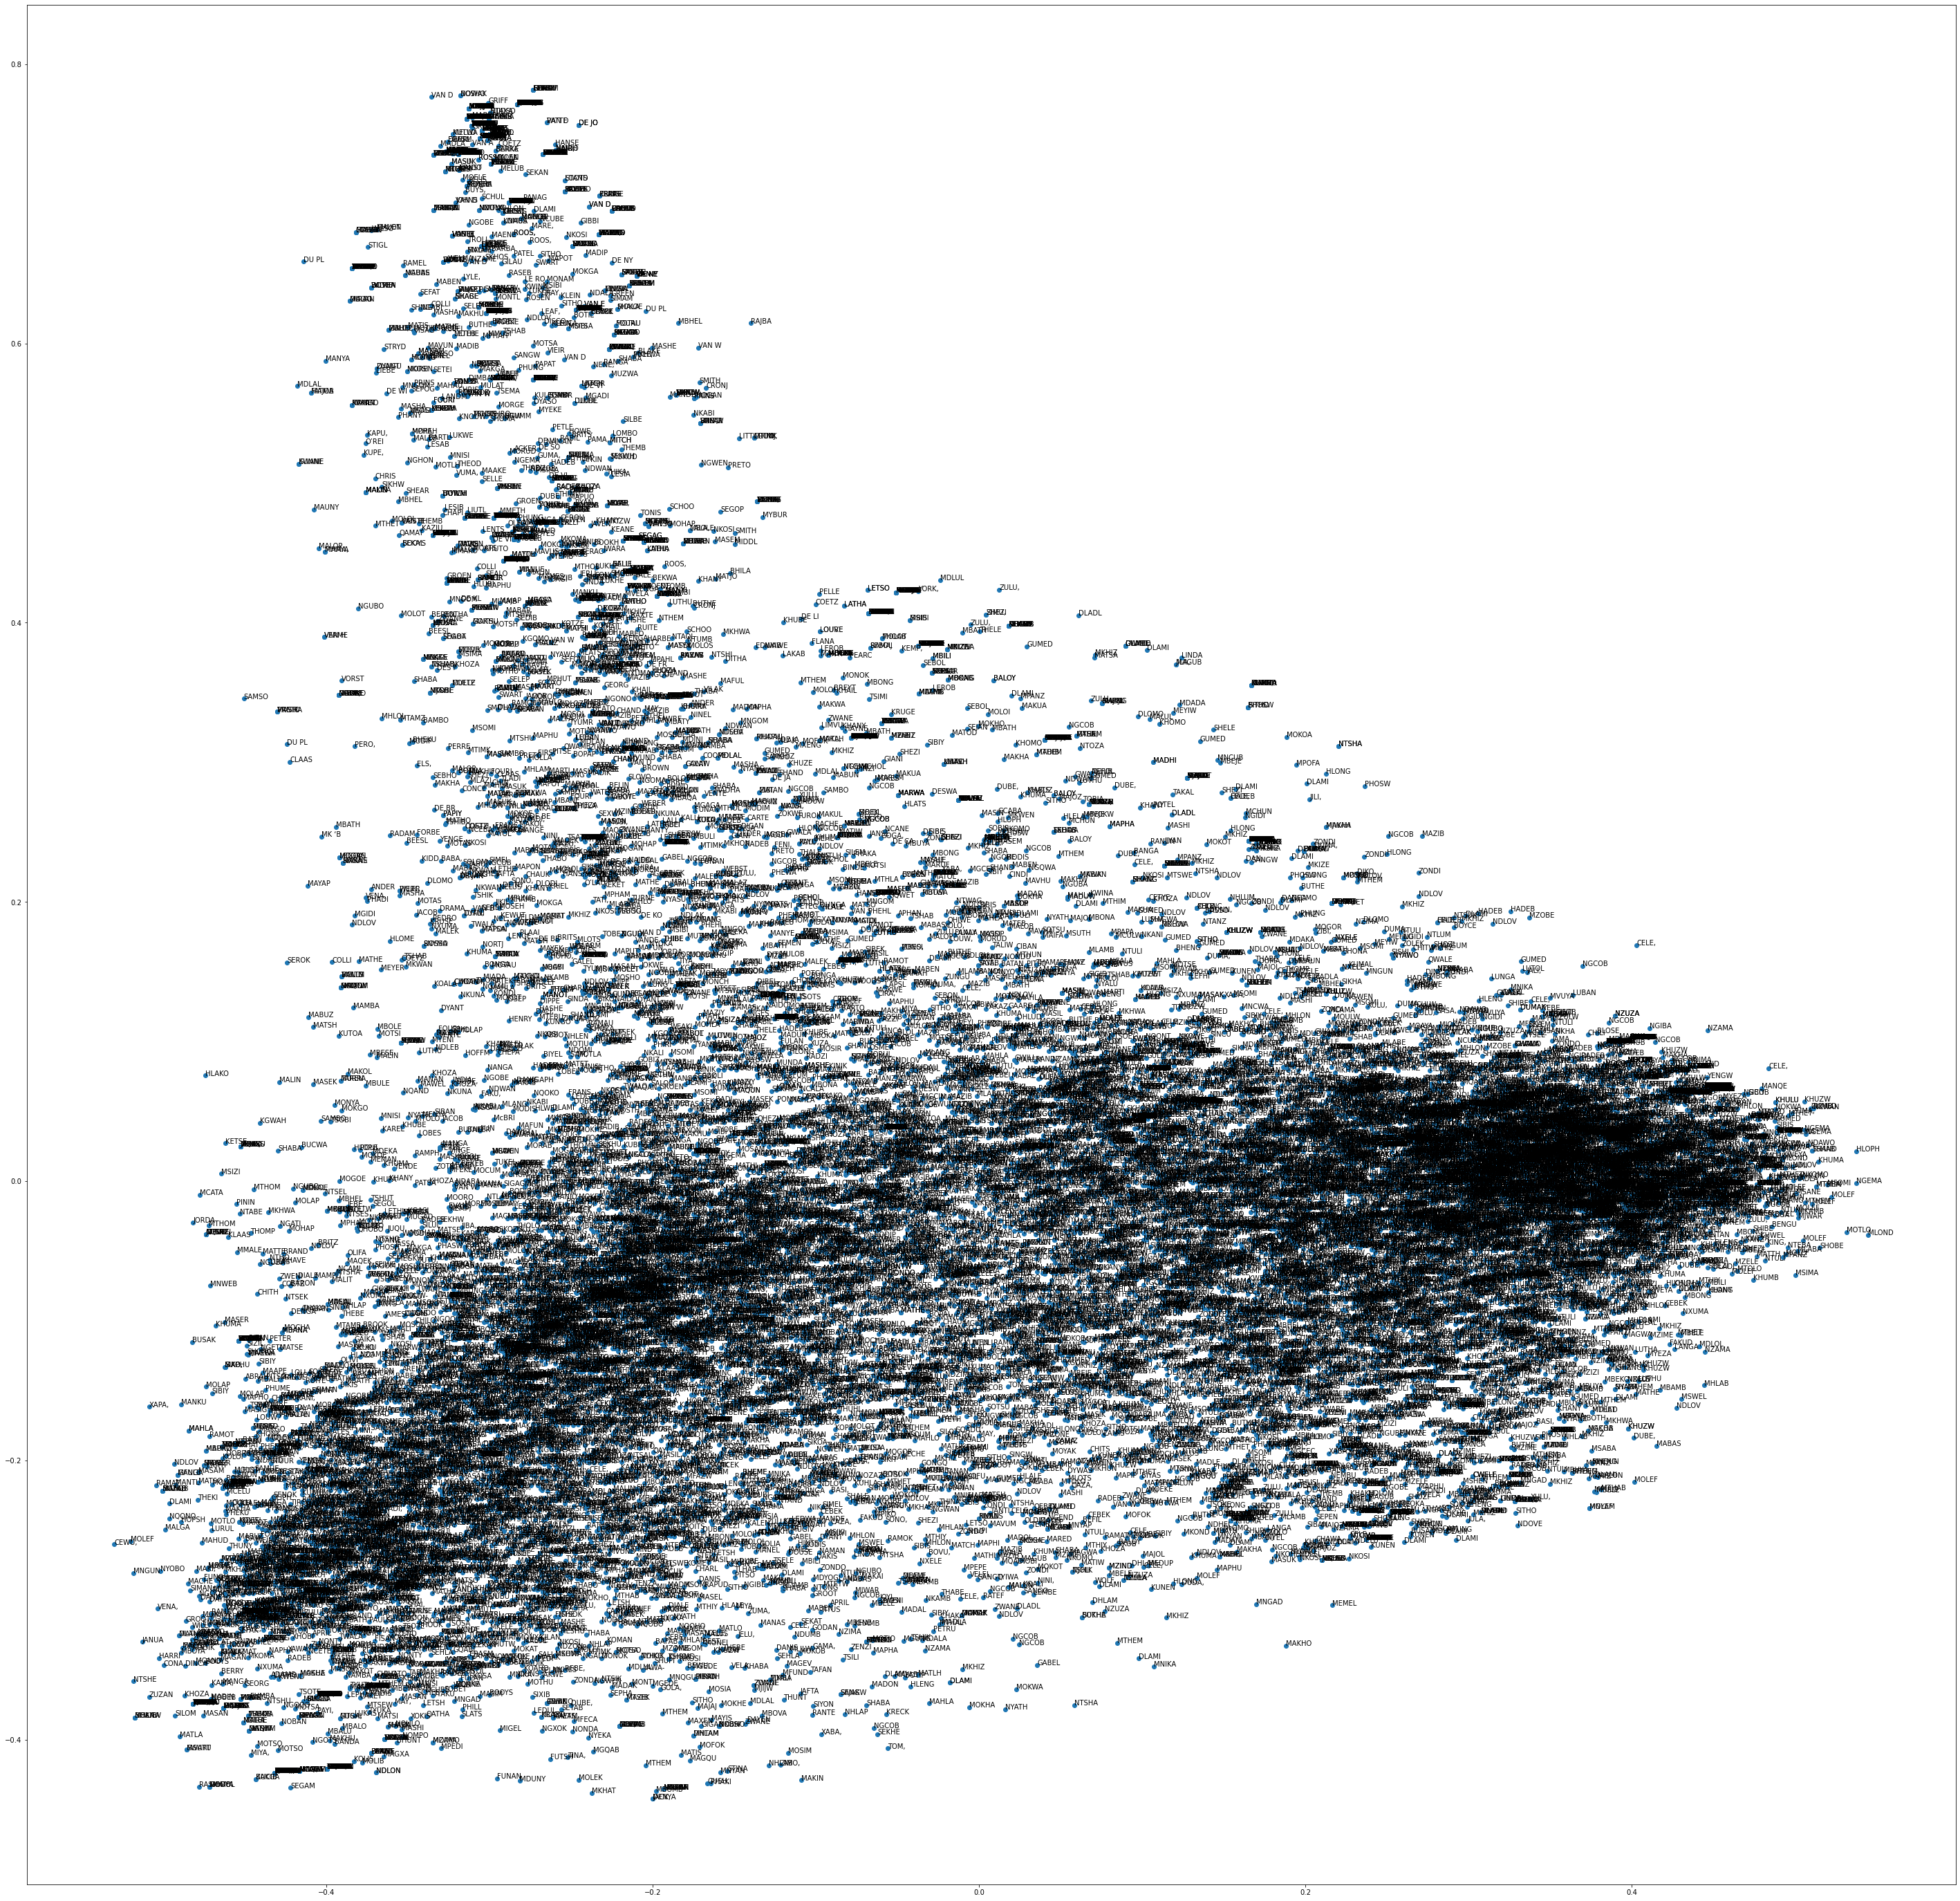

In [13]:
pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(vectors.toarray())
colors = ["r","b","c","y","m"]
x_axis = [o[0] for o in scatter_plot_points]

y_axis = [o[1] for o in scatter_plot_points]

fig, ax = plt.subplots(figsize=(50,50)) ##,c=[colors[d] for d in kmean_indices]


ax.scatter(x_axis,y_axis)

for i,txt in enumerate(names):
    ax.annotate(txt[0:5],(x_axis[i],y_axis[i]))
plt.savefig("trc.png")

## Latent Dirchlet Allocation

Better than K-MEANS Clusturing
In Kmeans each documet is clustured into a single document only.
However in LDA each document can have multiple topics


In [14]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ayushtripathi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
import numpy as np
import json
import glob

#Gensim

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#Spacy
import spacy
from nltk.corpus import stopwords

#vis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

In [16]:
def load_data(file):
    with open(file, "r", encoding="utf-8") as f:
        data = json.load(f)
    return (data)

def write_data(file,data):
    with open(file, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4)

In [17]:
stopwords = stopwords.words("english")
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [18]:
data = load_data("data/ushmm_dn.json")["texts"]
print(data[0][0:90])

 My name David Kochalski. I was born in a small town called , and I was born May 5, 1928. 


In [19]:
#!python -m spacy download en_core_web_lg
#!python -m spacy download en_core_web_sm
#!python -m spacy download en

In [20]:
def lemmatization(texts, allowed_postags= ["NOUN","ADJ","VERB","ADV"]):
    nlp = spacy.load("en_core_web_sm", disable= ["parser","ner"])
    text_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        text_out.append(final)
    return (text_out)
        
    

In [21]:
lemmatized_texts = lemmatization(data)
print(lemmatized_texts[0][0:90])

name bear small town call bear well very hard work child father mother small mill flour bu


In [22]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text,deacc=True)
        final.append(new)
    return (final)
    

In [23]:
data_words = gen_words(lemmatized_texts)
print(data_words[0][0:20])

['name', 'bear', 'small', 'town', 'call', 'bear', 'well', 'very', 'hard', 'work', 'child', 'father', 'mother', 'small', 'mill', 'flour', 'buckwheat', 'prosperous', 'comfortable', 'go']


### Add Bigrams and Trigrams

In [24]:
#BIGRAMS AND TRIGRAMS
bigram_phrases = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=100)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)

print (data_bigrams_trigrams[0][0:20])

['name', 'bear', 'small', 'town', 'call', 'bear', 'well', 'very', 'hard', 'work', 'child', 'father', 'mother', 'small', 'mill', 'flour', 'buckwheat', 'prosperous', 'comfortable', 'go']


In [25]:
print (data_bigrams_trigrams[0])

['name', 'bear', 'small', 'town', 'call', 'bear', 'well', 'very', 'hard', 'work', 'child', 'father', 'mother', 'small', 'mill', 'flour', 'buckwheat', 'prosperous', 'comfortable', 'go', 'school', 'public', 'school', 'morning', 'afternoon', 'go', 'religious', 'school', 'almost', 'late', 'night', 'well', 'raise', 'spirit', 'no', 'school', 'little', 'city', 'segregate', 'mind', 'small', 'town', 'say', 'majority', 'people', 'small', 'town', 'jewish', 'people', 'town', 'somehow', 'know', 'separate', 'jewish', 'child', 'catholic', 'child', 'know', 'most', 'people', 'use', 'friend', 'feel', 'maybe', 'personally', 'know', 'lot', 'incident', 'small', 'little', 'call', 'separate', 'other', 'word', 'hardly', 'get', 'together', 'incident', 'incident', 'pleasant', 'incident', 'call', 'house', 'people', 'regardless', 'religious', 'believe', 'really', 'religious', 'people', 'no', 'other', 'lovely', 'family', 'zionist', 'city', 'even', 'though', 'time', 'go', 'underground', 'religious', 'institution', 

In [26]:
#tf-idf removal
from gensim.models import TfidfModel
id2word = corpora.Dictionary(data_bigrams_trigrams)
# texts = data_bigrams_trigrams
corpus = [id2word.doc2bow(text) for text in data_bigrams_trigrams]

tfidf = TfidfModel(corpus, id2word=id2word)


#We are removing those words which has a high frequency and are repeated in the whole documents

low_value = 0.03
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

THE ISSUE WITH THIS METHOD IS IT WILL REMOVE IMPORTANT WORDS TOO WHICH HAVE HIGH FREQUENCY AMONG THE DOCUENTS. TO OVERCOME THIS WE CAN READ THE LIST OF WORDS AND CAN MANUALLY ADD THEM BACK IN THE LIST

In [27]:
# id2word = corpora.Dictionary(data_words)

# corpus = []
# for text in data_words:
#     new = id2word.doc2bow(text)
#     corpus.append(new)
    
# print(corpus[0][0:20])
# word = id2word[[0][:1][0]]
# print(word)

In [35]:
lda_model = gensim.models.ldamodel.LdaModel(corpus =corpus[:-1], # DOESN'T SEE THE LAST TEXT
                                           id2word = id2word,
                                           num_topics = 10,
                                           random_state = 100,
                                            update_every=1,
                                            chunksize= 100,
                                            passes = 10,
                                            alpha = "auto"
                                           )

In [38]:
#USE THE MODEL ON UNSEEN DATA

test_doc = corpus[-1]
vector = lda_model[test_doc]
print(vector)

#sort in desc order of weightage
def Sort(sub_li):
    sub_li.sort(key = lambda x:x[1]) # sort using second item
    sub_li.reverse()
    return (sub_li)
new_vector = Sort(vector)
print(new_vector)

[(0, 0.19906777), (1, 0.14866963), (3, 0.043152303), (4, 0.32704875), (5, 0.014795532), (8, 0.04568845), (9, 0.22090343)]
[(4, 0.32704875), (9, 0.22090343), (0, 0.19906777), (1, 0.14866963), (8, 0.04568845), (3, 0.043152303), (5, 0.014795532)]


In [40]:
#Save the Model

lda_model.save("models/test_model.model")

In [41]:
new_model = gensim.models.ldamodel.LdaModel.load("models/test_model.model")

# Visualize

In [39]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model,corpus,id2word,mds="mmds",R=30) # use gensim_models instead of gensim
vis

/Users/ayushtripathi/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/ayushtripathi/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/ayushtripathi/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/ayushtripathi/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/ayu

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.257143 -0.190391       1        1  16.006037
6      0.125724  0.188449       2        1  13.916415
3     -0.153019  0.147556       3        1  13.342732
8      0.298113 -0.032198       4        1  13.036314
1      0.190079 -0.252056       5        1  11.369188
7      0.286270  0.221858       6        1   9.243037
2     -0.041600  0.338321       7        1   7.729515
9     -0.030213 -0.354587       8        1   7.170656
4     -0.366434  0.075530       9        1   6.924187
5     -0.051778 -0.142482      10        1   1.261919, topic_info=          Term         Freq        Total Category  logprob  loglift
2274    ghetto  2139.000000  2139.000000  Default  30.0000  30.0000
849        use  1381.000000  1381.000000  Default  29.0000  29.0000
569       over   928.000000   928.000000  Default  28.0000  28.0000
662   remember   888.000000   888.000000  Default  27.0000  27.0000
442       kill  1331.000000  1331.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
2111      yard     8.594981    90.986016  Topic10  -5.6400   2.0130
1609   officer    10.759691   294.486413  Topic10  -5.4154   1.0631
576      paper    10.400308   341.746387  Topic10  -5.4494   0.8803
705       sell     7.967060   114.887569  Topic10  -5.7159   1.7039
38     anymore     7.055395   184.421210  Topic10  -5.8374   1.1091

[719 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
3335      4  0.979162  abandon
0         1  0.312161     able
0         3  0.149736     able
0         4  0.015227     able
0         5  0.020303     able
...     ...       ...      ...
901       1  0.158752  zionist
901       2  0.043296  zionist
901       5  0.057728  zionist
901       6  0.057728  zionist
901       7  0.678305  zionist

[1616 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 4, 9, 2, 8, 3, 10, 5, 6])

# Issues with above

If you see the clusture they are not very well formed. Since words like go, would,so have higher frequency as compared to other words. This is not good as it doesn't add any values.

# 